In [5]:
import torch
import torch.linalg as alg
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, HypergraphConv

from dataHandler import ParticleDataset
from manifold import PoincareBall
manifold = PoincareBall()

import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

In [157]:
def hyper_dist(point_a,point_b):
    #point_a = poincare._clip_vectors(point_a)
    #point_b = poincare._clip_vectors(point_b)

    #if len(point_a.shape) < 2:
    #    point_a = th.unsqueeze(point_a, 0)
    #if len(point_b.shape) < 2:
    #    point_b = th.unsqueeze(point_b, 0)

    sq_norm_a = alg.norm(point_a,axis=1) ** 2.
    sq_norm_b = alg.norm(point_b,axis=1) ** 2.
    sq_norm_ab = alg.norm(point_a - point_b,axis=1) ** 2.

    cosh_angle = 1 + 2 * sq_norm_ab / (1 - sq_norm_a) / (1 - sq_norm_b)
    cosh_angle = torch.clamp(cosh_angle, min=1.+1e-6)
    dist = torch.acosh(cosh_angle)
    return dist


def distance_matrix(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        #matrix[n_idx] = torch.cdist(torch.unsqueeze(nodes[n_idx],0),nodes)
        matrix[n_idx] = hyper_dist(torch.unsqueeze(nodes[n_idx],0),nodes) + 1e-8
    return matrix

def distance_matrix2(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        matrix[n_idx] = torch.cdist(torch.unsqueeze(nodes[n_idx],0),nodes)
        #matrix[n_idx] = poincare.distance(torch.unsqueeze(nodes[n_idx],0),nodes)
    return matrix

In [6]:
dataset = ParticleDataset('data/test/','background')
#data = dataset.__getitem__(0)
data_batches = DataLoader(dataset,batch_size=4,shuffle=False,num_workers=128)

In [8]:
class gnn(torch.nn.Module):
    def __init__(self,_in,_h1,_h2,_out):
        super().__init__()
        self.conv1 = HypergraphConv(_in,_h1,dropout=0.1)
        self.conv2 = HypergraphConv(_h1,_h2,dropout=0.1)
        self.conv3 = HypergraphConv(_h2,_out,dropout=0.1)
        
        self.epsilon = 1e-1
        self.thresh = 1.0 - self.epsilon
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        for row_id in range(len(x)):
            x[row_id] = poincare.exp_map(x[row_id],torch.zeros_like(x[0]))
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        
        '''
        norms = alg.norm(x,axis=1)
        if (norms < self.thresh).all() == False:
            x_copy = torch.clone(x)
            x_copy[norms >= self.thresh] *= (self.thresh / norms[norms >= self.thresh])[:,None]
            x = x_copy
        '''
        #x = poincare._clip_vectors(x)
        return x

In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gnn(4,64,64,2).to(device)
model.double()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [144]:
model.train()
torch.autograd.set_detect_anomaly(True)
for epoch in range(1):
    loss = []
    t = time()
    count = 0
    for batch in data_batches:
        optimizer.zero_grad()
        out = model(batch)
        loss_temp = 0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = out[graph_mask]
            _y = batch.y[graph_mask]
            
            _input = distance_matrix(_x)
            _target = distance_matrix(_y)
        
            loss_temp += F.mse_loss(_input,_target)
            print(f'graph number: {count}, loss_temp: {loss_temp}')
            count+=1
        loss_temp /= batch.num_graphs    
        loss.append(loss_temp)
        
        loss_temp.backward()
        optimizer.step()
        print(f'batch:{count}, mean loss:{torch.mean(loss_temp.clone().detach())}, \
          time {round(time()-t,2)}')
        count+=1
        
    loss = torch.tensor(loss)
    print(f'epoch:{epoch}, mean loss:{torch.mean(loss.clone().detach())}, \
          time {round(time()-t,2)}')

graph number: 0, loss_temp: 6.707857608795166
graph number: 1, loss_temp: 13.596183776855469
graph number: 2, loss_temp: 20.743505477905273
graph number: 3, loss_temp: 26.82996940612793
batch:4, mean loss:6.707492351531982,           time 19.82
graph number: 5, loss_temp: 2.952507257461548
graph number: 6, loss_temp: 6.036515235900879
graph number: 7, loss_temp: 9.610318183898926
graph number: 8, loss_temp: 11.817001342773438
batch:9, mean loss:2.9542503356933594,           time 29.94
graph number: 10, loss_temp: 5.735039234161377
graph number: 11, loss_temp: 10.133493423461914
graph number: 12, loss_temp: 16.856407165527344
graph number: 13, loss_temp: 22.387880325317383
batch:14, mean loss:5.596970081329346,           time 39.4


Process Process-2601:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2adea3f093a0>
Traceback (most recent call last):
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/selectors.py",

KeyboardInterrupt: 

In [11]:
torch.save(model,'model_scripted.pt')

# Example 

loss is: 6.381307601928711


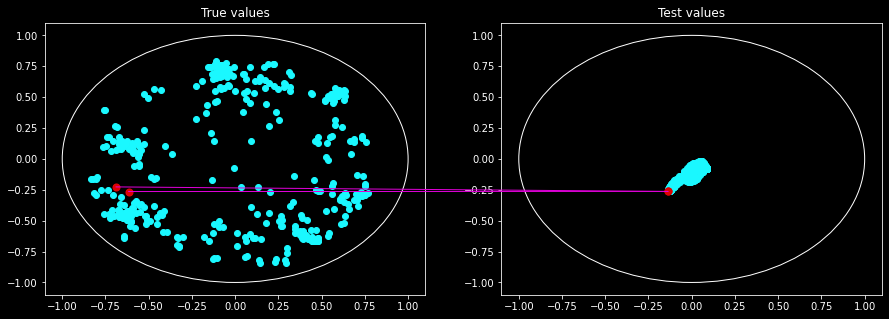

In [162]:
#model = torch.load('model_scripted.pt',map_location=torch.device('cpu'))
#model.eval()
data = dataset.__getitem__(0)
out = model(data)
#out = hgnn.hgnn(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = out.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='white',fill=False)
disk2 = Circle((0,0),1,color='white',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)

length = len(out)
_input = distance_matrix(out)
_input = _input[torch.triu(torch.ones(length,length),diagonal=1) == 1]
_target = distance_matrix(data.y)
_target = _target[torch.triu(torch.ones(length,length),diagonal=1) == 1]
loss = F.mse_loss(_input,_target)
print(f'loss is: {loss}')
plt.show()

## Playing with my own gnn

In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

from layers.hyp_layer import HyperbolicGraphConvolution as HypGCN
from manifold.poincare import PoincareBall
from dataHandler import ParticleDataset
from optimizer.radam import RiemannianAdam

import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

In [2]:
manifold = PoincareBall() #initialise the manifold

train = ParticleDataset('data/test','background')
#train = DataLoader(train, batch_size=4, shuffle=True,num_workers=128)

# use 20% of training data for validation
train_set_size = int(len(train) * 0.8)
valid_set_size = len(train) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(train, [train_set_size, valid_set_size], generator=seed)
train_set = DataLoader(train_set,batch_size=4,num_workers=128)
valid_set = DataLoader(valid_set,batch_size=4,num_workers=128)

test = ParticleDataset('data/test','background')
test_set = DataLoader(test, batch_size=4,num_workers=128)

In [3]:
#activation = torch.tanh
class hgcn(torch.nn.Module):
    def __init__(self, manifold, _in, _h1, _out):
        super().__init__()
        self.hconv1 = HypGCN(manifold, _in-1, _h1)
        self.hconv2 = HypGCN(manifold, _h1, _out)
                
    def forward(self,data):
        x, edge_index = manifold.lorentz_to_poincare(data.x), data.edge_index
        
        x = self.hconv1(x, edge_index)
        x = self.hconv2(x, edge_index)
        
        return x

In [4]:
def distance_matrix(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        matrix[n_idx] = manifold.distance(torch.unsqueeze(nodes[n_idx],0),nodes) + 1e-8
    return matrix[torch.triu(torch.ones_like(matrix),diagonal=1) == 1]

In [5]:
class LitHGCN(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.hyp_gcn = model(manifold, 4, 64, 2).double()
        
    def forward(self,batch):
        #batch.x = manifold.lorentz_to_poincare(batch.x)
        output = self.hyp_gcn(batch)
        return output

    def training_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        
        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])

            loss_temp += F.mse_loss(_input,_target)
        
        loss_temp /= batch.num_graphs
        '''
        _output = distance_matrix(output)
        _target = distance_matrix(batch.y)
        loss_temp = F.mse_loss(_target,_output)
        '''
        self.log('training loss',loss_temp)
        return loss_temp

    
    def validation_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])


            loss_temp += F.mse_loss(_output,_target)
        
        loss_temp /= batch.num_graphs
        self.log('valid loss',loss_temp,batch_size=len(torch.unique(batch.batch)))
        
    
    def test_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])

            loss_temp += F.mse_loss(_output,_target)
        
        loss_temp /= batch.num_graphs
        self.log('test loss',loss_temp,batch_size=len(torch.unique(batch.batch)))
        
    
    def configure_optimizers(self):
        optimizer = RiemannianAdam(self.hyp_gcn.parameters(),
            lr=0.05, weight_decay=5e-4)
        return optimizer

In [6]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running training ...')
        return bar

In [7]:
hyper_gcn = LitHGCN(hgcn)
bar = LitProgressBar()

trainer = pl.Trainer(max_epochs=1,callbacks=[bar],log_every_n_steps=1)
#trainer.fit(hyper_gcn,train_set,valid_set)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
#trainer.test(model=hyper_gcn,test_dataloaders=test_set)

In [5]:
PATH = 'scripts/lightning/model.ckpt'
old_dict = torch.load(PATH)['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in old_dict.items():
    name = k[8:] # remove `module.`
    new_state_dict[name] = v
    
model = hgcn(manifold, 4, 64, 2).double()

model.load_state_dict(new_state_dict)
model.eval()

hgcn(
  (hconv1): HyperbolicGraphConvolution(
    (linear): HyperbolicLinear()
    (attention): HyperbolicAttention(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (hconv2): HyperbolicGraphConvolution(
    (linear): HyperbolicLinear()
    (attention): HyperbolicAttention(
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
)

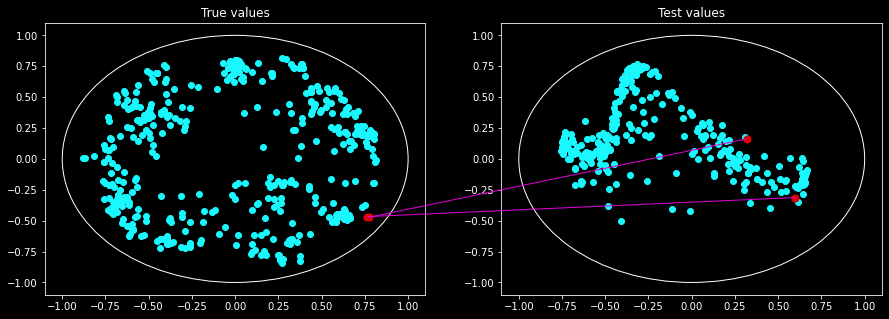

In [8]:
checking = ParticleDataset('data/test','background')
data = checking.__getitem__(2)

#hyp_gcn = hgcn(manifold, 4, 64, 2).double()
#hgcn.eval()
output = model(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = output.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='white',fill=False)
disk2 = Circle((0,0),1,color='white',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)

plt.show()